In [1]:
import torch
from components import NeuralProcess
from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D
from torch import nn

from utils import DataModule, MetaLearningDataset
from train_val import train_and_validate

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [5]:
benchmark = Sinusoid1D(
    n_task=4096,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=128,
    dataset_and_split=(dataset, (0.8, 0.2)),
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 201942.67it/s]


In [4]:
model = NeuralProcess(
    x_dim=1, 
    y_dim=1, 
    r_dim=16, 
    z_dim=16, 
    h_dim=128, 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
recon_criterion = nn.MSELoss(reduction='mean')

In [5]:
avg_train_recon_losses, avg_train_kl_divs, avg_val_recon_losses, avg_val_kl_divs = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=60,
    device=device,
    optimizer=optimizer,
    recon_criterion=recon_criterion,
    kl_reduction='mean',
)

  0%|          | 0/23 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 10/10 [00:00<00:00, 46.51it/s, epoch=59, kl_div=0.274, recon_loss=0.474]


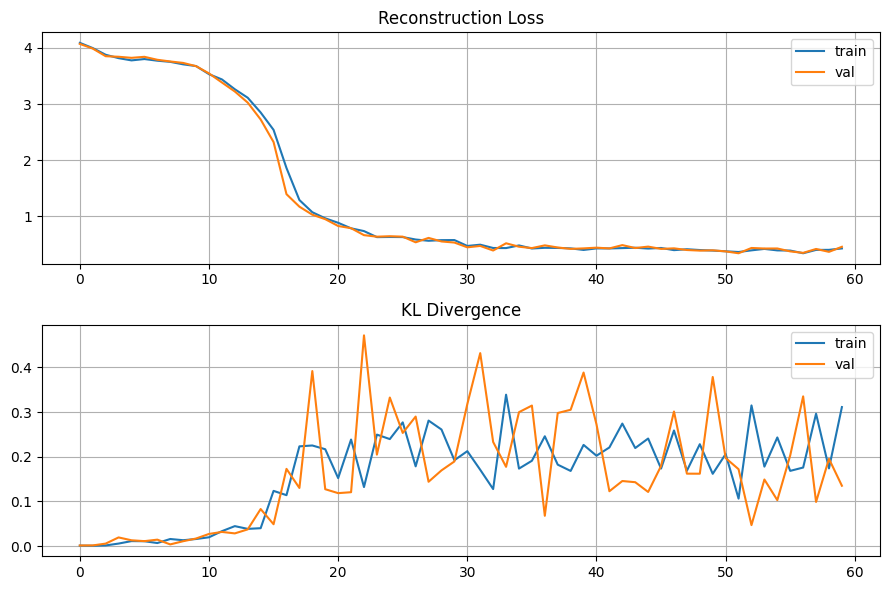

In [6]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_recon_losses, label="train")
ax[0].plot(avg_val_recon_losses, label="val")
ax[0].set_title("Reconstruction Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()